In [1]:
from PIL import Image
import colorsys

# Constants
width = 1000
x_center = -0.65
y_center = 0
x_range = 3.4
aspect_ratio = 4/3 

precision = 500

# Derived constants
height = round(width / aspect_ratio)
y_range = x_range / aspect_ratio
min_x = x_center - x_range / 2
max_x = x_center + x_range / 2
min_y = y_center - y_range / 2
max_y = y_center + y_range / 2

def power_color(distance, exp, const, scale):
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color,1 - 0.6 * color,0.9)
    return tuple(round(i * 255) for i in rgb)

def generate_fractal(width, height, min_x, max_x, min_y, max_y, precision):
    img = Image.new('RGB', (width, height), color='black')
    pixels = img.load()

    for row in range(height):
        for col in range(width):
            x = min_x + col * (max_x - min_x) / width
            y = max_y - row * (max_y - min_y) / height
            old_x, old_y = x, y
            for i in range(precision + 1):
                a = x*x - y*y  # Real component of z^2
                b = 2 * x * y  # Imaginary component of z^2
                x = a + old_x  # Real component of new z
                y = b + old_y  # Imaginary component of new z
                if x*x + y*y > 4:
                    break
            if i < precision:
                distance = (i + 1) / (precision + 1)
                rgb = power_color(distance, 0.2, 0.35, 1.0)
                pixels[col, row] = rgb

    return img.save('output.png')


# Generate the fractal image
fractal_image = generate_fractal(width, height, min_x, max_x, min_y, max_y, precision)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from statistics import mean, stdev
warnings.simplefilter("ignore")

def complex_matrix(xmin, xmax, ymin, ymax, pixeldensity):
    """creates a complex matrix for the mandelbrot set to be plotted on with dimensions of pixeldensity*pixeldensity

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image

    Returns:
        complex matrix: retuns a complex matrix of linearly spaced complex numbers
    """
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixeldensity))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixeldensity))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j 

def is_stable(c, num_iterations):
    """calculates the stability of a point in the mandelbrot set by iterating z = z^2 + c num_iterations times and determining if the point is inside or outside the mandelbrot set

    Args:
        c (complex matrix): complex matrix to iterate over
        num_iterations (int): number of iterations to iterate over before deciding if the point is inside or outside the mandelbrot set

    Returns:
        matrix: matrix values consisiting of True if the point is inside the mandelbrot set and False if the point is outside the mandelbrot set
    """
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2
    

def point_inside(x_array, y_array, iterations):
    """determines if a list of points are either inside or outside the mandelbrot set

    Args:
        x_array (list): list of x coordinates of points to be tested
        y_array (list): list of y coordinates of points to be tested
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set

    Returns:
        list: list of boolean values, true if the point is inside the mandelbrot set, false if the point is outside the mandelbrot set
    """
    truth_values = []
    for i in range(0, len(x_array)):
        z_0 = 0
        c = complex(x_array[i], y_array[i])

        for i in range(iterations):
            z_0 = z_0 ** 2 + c
            if abs(z_0) > 2:
                truth_values.append(False)
                break
            if i == iterations - 1:
                truth_values.append(True)
    return truth_values

def random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """randomly creates points within the mandelbrot set to be tested

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        samples (int): number of samples to take

    Returns:
        list: returns list cosnisting of random x and y points, and the same points scaled to the image dimensions to be plotted on the mandelbrot set image
    """
    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []
    for i in range(0, samples):
        random_x = random.uniform(xmin, xmax)
        random_x_axis.append(random_x)

        random_y = random.uniform(ymin, ymax)
        random_y_axis.append(random_y)

        random_x_axis_plotted.append((random_x+abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((random_y+abs(ymin))*pixeldensity)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

def latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """creates a grid of samples*samples size grid and randomly samples from each row and column to create a latin hypercube

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image 
        samples (int): number of samples to take, namely how large the grid will be

    Returns:
        list: returns 4 lists of equal size, the x and y points of the randomly selected latin hypercube points and the x and y points of the latin hypercube scaled to the image dimensions
    """
    x_points = np.linspace(xmin, xmax, samples+1)
    y_points = np.linspace(ymin, ymax, samples+1)

    bin_size = x_points[1] - x_points[0]

    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    while (y_points.shape[0] != 0):
        random_x = random.randint(0, x_points.shape[0]-1)
        random_x_bin = random.uniform(0, bin_size)
        random_x_axis.append(x_points[random_x] + random_x_bin)

        random_y = random.randint(0, y_points.shape[0]-1)
        random_y_bin = random.uniform(0, bin_size)
        random_y_axis.append(y_points[random_y] + random_y_bin)

        random_x_axis_plotted.append((x_points[random_x] + random_x_bin + abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((y_points[random_y] + random_y_bin + abs(ymin))*pixeldensity)

        x_points = np.delete(x_points, random_x)
        y_points = np.delete(y_points, random_y)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted


def orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """divides the grid into sqrt(samples)xsqrt(samples) subspaces and randomly samples from each block

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image 
        samples (int): number of samples to take, namely how large the grid will be

    Returns:
        list: returns 4 lists of equal size, the x and y points of the randomly selected orthogonal points and the x and y points of the orthogonal scaled to the image dimensions
    """
    if samples != np.sqrt(samples)**2:
        raise ValueError("The square root of the sample size must equal an integer.")

    number_subspaces = int(np.sqrt(samples))

    x_intervals = np.linspace(xmin, xmax, number_subspaces + 1)
    y_intervals = np.linspace(ymin, ymax, number_subspaces + 1)

    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    for i in range(number_subspaces):
        for j in range(number_subspaces):

            x_min, x_max = x_intervals[i], x_intervals[i+1]
            y_min, y_max = y_intervals[j], y_intervals[j+1]

            random_x = random.uniform(x_min, x_max)
            random_y = random.uniform(y_min, y_max)

            random_x_axis.append(random_x)
            random_y_axis.append(random_y)

            random_x_axis_plotted.append((random_x - xmin) * pixeldensity)
            random_y_axis_plotted.append((random_y - ymin) * pixeldensity)

    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted
    

def calculate_i_s(c, iterations, samples, numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        c (complex matrix): complex matrix of mandelbrot set
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        samples (int): number of samples to take
        numberruns (int): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        typeof (string): type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        printimage (bool, optional): Determines if image of mandelbort image is printed in output for each iteration. Defaults to False.
        saveimage (bool, optional): Determines if image of mandelbort image is saved to hard disk for each iteration. Defaults to False.

    Returns:
        ratio, area: returns the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set
    """

    stable_points = is_stable(c, iterations)

    list_ratio_in_to_out = []
    list_estimated_area = []

    for i in range(0, numberruns):
        if (typeof == "Random"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Latin"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Orthogonal"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        else:
            print("Please enter a valid type of sampling")
            return

        inside_outside = point_inside(random_x_axis, random_y_axis, iterations)
        number_true = sum(inside_outside)
        ratio_in_to_out = number_true/samples
        estimated_area = ratio_in_to_out*(xmax-xmin)*(ymax-ymin)

        list_ratio_in_to_out.append(ratio_in_to_out)
        list_estimated_area.append(estimated_area)
    
    ratio_in_to_out = round(mean(list_ratio_in_to_out), 4)
    estimated_area = round(mean(list_estimated_area), 4)
    estimated_area_sd = round(stdev(list_estimated_area), 4)
    
    print("Ratio of in to out for randomly selected points over {} samples:".format(numberruns), ratio_in_to_out)
    print("Estimated area of mandelbrot set over {} samples:".format(numberruns), estimated_area)
    fig, ax1 = plt.subplots(1,1)
    plt.imshow(stable_points)
    ax1.scatter(random_x_axis_plotted, random_y_axis_plotted, c=inside_outside, s=1, cmap="coolwarm")
    ax1.axhline(pixeldensity, color="green", lw=1)
    ax1.axvline(pixeldensity*2, color="green", lw=1)
    plt.gca().set_aspect("equal")
    plt.xlabel("Real Axis")
    plt.ylabel("Imaginary Axis")
    ax1.set_title("Mandelbrot Set with {} Iterations and {} Samples. \n Estimated Area of Using the {} Algorithm is {} \n Sampled {} times (SD = {})".format(iterations, samples, typeof, estimated_area, numberruns, estimated_area_sd))
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.axis('off')

    if (saveimage):
        image_name =  typeof + '_' + str(iterations) + "_" + str(samples) + '_' + str(estimated_area) + ".png"
        plt.savefig("PlotImages/" + image_name)
        print("Image saved as: ", image_name)
    
    if (printimage):
        plt.show()
    plt.close()
    return (ratio_in_to_out, estimated_area, estimated_area_sd)


def run_simulation(numberiterations, numbersamples, numberruns, typeof, xmin=-2, xmax=0.5, ymin=-1, ymax=1, pixeldensity=1000, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        numberiterations (list): list of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        numbersamples (list): list of samples to take
        typeof (string): string of type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        xmin (float, optional): min value of x axis for mandelbrot set. Defaults to -2.
        xmax (float, optional): max value of x axis for mandelbrot set. Defaults to 0.5.
        ymin (float, optional): min vlaue of y axis for mandelbrot set. Defaults to -1.
        ymax (float, optional): max vlaue of y axis for mandelbrot set. Defaults to 1.
        pixeldensity (int, optional): number of pixels for image. Defaults to 1000.
        printimage (bool, optional): choose if you want images to be printed to output cell. Defaults to False.
        saveimage (bool, optional): choose if you want image to be saved to hard drive. Defaults to False.
    """
    data_results = []
    c_m = complex_matrix(xmin, xmax, ymin, ymax, pixeldensity)

    for i in range(len(numberiterations)):
        for j in range(len(numbersamples)):
            print("Number of iterations:", numberiterations[i])
            print("Number of samples:", numbersamples[j])
            ratio, area, stdev = calculate_i_s(c_m, numberiterations[i], numbersamples[j], numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage, saveimage)
            data_results.append([numberiterations[i], numbersamples[j], ratio, area, stdev])
            print('\n')

    file = open('data_results_{}.txt'.format(typeof), 'w')
    file.write('Number of Iterations, Number of Samples, Ratio of In to Out, Estimated Area, Standard Deviation, Saved Photo Name\n')
    for item in data_results:
        file_name = typeof + '_' + str(item[0]) + '_' + str(item[1]) + '_' + str(item[3]) + '_' + str(item[4]) + '.png'
        file.write(str(item[0]) + ', ' + str(item[1]) + ', ' + str(item[2]) + ', ' + str(item[3]) + ', ' + str(item[4]) + ', ' + file_name + '\n')
    file.close()
    print("data results (iterations, samples, number of runs, ratio of in to out dots, estimated area, standard_deviation, and photo name) has been saved in data_results_{}.txt".format(typeof))

Number of iterations: 100
Number of samples: 1000
Ratio of in to out for randomly selected points over 5 samples: 0.2984
Estimated area of mandelbrot set over 5 samples: 1.492
Image saved as:  Orthogonal_100_1000_1.492.png


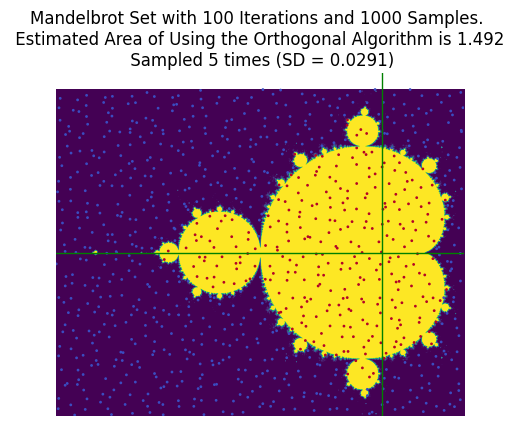



Number of iterations: 100
Number of samples: 5000
Ratio of in to out for randomly selected points over 5 samples: 0.3021
Estimated area of mandelbrot set over 5 samples: 1.5104
Image saved as:  Orthogonal_100_5000_1.5104.png


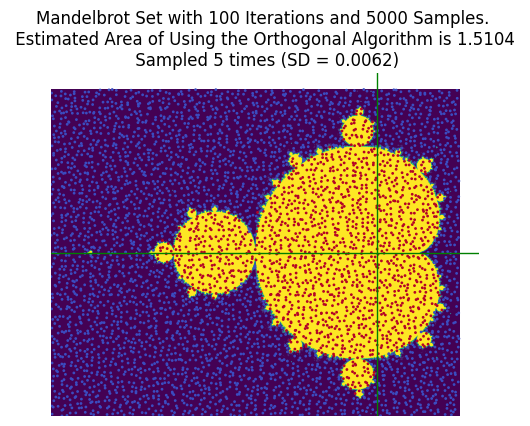



data results (iterations, samples, number of runs, ratio of in to out dots, estimated area, standard_deviation, and photo name) has been saved in data_results_Orthogonal.txt


In [16]:
number_iterations = [100] #, 200, 300, 400, 500]
number_samples = [1000, 5000] #, 2000, 3000, 4000, 5000]
run_simulation(number_iterations, number_samples, 5, "Orthogonal", printimage = True, saveimage = True)